In [167]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [168]:
# file  = "HSt42_0/test_200_800day.dat"
# ds = h5py.File(file, "r")
# # print(ds.keys())
# dycore = Dycore(file)
# u = dycore.getVar("grid_u_c_xyzt")
# # print(u.shape)

In [169]:
file  = "HSt42_5/RH80_PR5_1000day_startfrom_100day_final.dat"
# file = "RH50_test_f0_all.dat"
ds = h5py.File(file, "r")
print(ds.keys())

print(np.nanmax(np.asarray(ds["grid_u_c_xyzt"])))


<KeysViewHDF5 ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']>
101.40068106380457


In [170]:
lat_0 = np.array([-1.5335125830545813, -1.485214577958351, -1.4366313478480872, -1.3879836743385505, -1.3393115571950114, -1.2906276131055214, -1.241937060919817, -1.1932424462905298, -1.144545157917862, -1.0958460174998903, -1.0471455422784188, -0.9984440741325684, -0.9497418481523823, -0.9010390313853844, -0.8523357458658898, -0.8036320828934408, -0.7549281122089407, -0.7062238880767123, -0.6575194534257702, -0.6088148427373913, -0.5601100841016827, -0.5114052007106801, -0.4627002119616472, -0.41399513428591594, -0.3652899817814796, -0.31658476670341296, -0.26787949985019416, -0.21917419087322776, -0.17046884852950536, -0.12176348089226514, -0.07305809553098731, -0.024352699669631092, 0.024352699669631092, 0.07305809553098731, 0.12176348089226514, 0.17046884852950536, 0.21917419087322776, 0.26787949985019416, 0.31658476670341296, 0.3652899817814796, 0.41399513428591594, 0.4627002119616472, 0.5114052007106801, 0.5601100841016827, 0.6088148427373913, 0.6575194534257702, 0.7062238880767123, 0.7549281122089407, 0.8036320828934408, 0.8523357458658898, 0.9010390313853844, 0.9497418481523823, 0.9984440741325684, 1.0471455422784188, 1.0958460174998903, 1.144545157917862, 1.1932424462905298, 1.241937060919817, 1.2906276131055214, 1.3393115571950114, 1.3879836743385505, 1.4366313478480872, 1.485214577958351, 1.5335125830545813]) * 180 / np.pi
lat = np.broadcast_to(lat_0, (20, 128, 64))


In [171]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.u_p  = self.getVar("grid_u_p_xyzt")
        self.u_n  = self.getVar("grid_u_n_xyzt")
        
        
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        self.qv_n = self.getVar("grid_tracers_n_xyzt")
        
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        # self.factor4 = self.getVar("factor4_xyzt")


        self.convection = self.getVar("convection_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

In [172]:
def plot_EMF_80(pr):
    qv_all = np.zeros(((9, 100, 20 , 64, 128)))
    qv_diff_all = np.zeros(((9, 100, 20 , 64, 128)))
    u_all = np.zeros(((9, 100, 20 , 64, 128)))
    v_all = np.zeros(((9, 100, 20 , 64, 128)))
    t_all = np.zeros(((9, 100, 20 , 64, 128)))
    p_all = np.zeros(((9, 100, 20 , 64, 128)))
    p_half_all = np.zeros(((9, 100, 21 , 64, 128)))

    a = 0
    for day in range(200,1100,100):
        print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        qv_all[a,:,:,:,:]   = dycore.qv
        qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        u_all[a,:,:,:,:]    = dycore.u
        v_all[a,:,:,:,:]    = dycore.v
        t_all[a,:,:,:,:]    = dycore.t
        p_all[a,:,:,:,:]    = dycore.p
        p_half_all[a,:,:,:,:]    = dycore.p_half
        
        print(a)
        a+=1
    qv_all_new      = np.nanmean(qv_all  , axis=0)
    qv_diff_new      = np.nanmean(qv_diff_all  , axis=0)
    u_new      = np.nanmean(u_all  , axis=0)
    v_new      = np.nanmean(v_all  , axis=0)
    t_new      = np.nanmean(t_all  , axis=0)
    p_new      = np.nanmean(p_all  , axis=0)
    p_half_new      = np.nanmean(p_half_all  , axis=0)
    


    qv = qv_all_new
    qv_diff = qv_diff_new
    u = u_new
    v = v_new
    t = t_new
    p = p_new
    p_half = p_half_new
    
    

    
    # file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_1000day_final.dat"
    

    # dycore = Dycore(file)
    
    # qv = dycore.getVar("grid_tracers_c_xyzt")
    # u = dycore.getVar("grid_u_c_xyzt")
    # v = dycore.getVar("grid_v_c_xyzt")
    # t = dycore.getVar("grid_t_c_xyzt")
    # p  = dycore.getVar("grid_p_full_xyzt")
    # p_half  = dycore.getVar("grid_p_half_xyzt")
    # qv_diff = dycore.getVar("grid_tracers_diff_xyzt")
    
    # p = dycore.getVar("grid_p_full_xyzt")
    # sigma = dycore.getVar("grid_p_full_xyzt") / dycore.getVar("grid_ps_xyzt")

    v_prime = np.rollaxis((np.rollaxis(v, 3, 0) - np.nanmean(v, axis=3)), 0, 4)
    u_prime = np.rollaxis((np.rollaxis(u, 3, 0) - np.nanmean(u, axis=3)), 0, 4)
    t_prime = np.rollaxis((np.rollaxis(t, 3, 0) - np.nanmean(t, axis=3)), 0, 4)
    qv_prime = np.rollaxis((np.rollaxis(qv, 3, 0) - np.nanmean(qv, axis=3)), 0, 4)

    tmp = np.nanmean(u[:,:,32:,:], axis=(0, 3))
    jet_k, _ = np.unravel_index(tmp.argmax(), tmp.shape)
    b = t_prime / np.nanmean(t) * 9.81

    eddy_flux_momentum = np.nanmean(u_prime * v_prime, axis=(0, 3))
    
    eddy_flux_q = np.nanmean(qv_prime * v_prime, axis=(0, 3))

    eddy_flux_heat = np.nanmean(b * v_prime, axis=(0, 1, 3))
    
    eddy_flux_kinetic = 0.5 * np.nanmean((u_prime**2 + v_prime**2)**0.5, axis=(0, 3))
    
    ###
    # qv_diff_sum = np.nansum(qv_diff[:,:,:,:], axis=(0,1,3))
    g = 9.81
    prec = np.zeros(u.shape)
    for i in range(1,20-1):
        prec[:,i,:,:] = 1 / g * qv_diff[:,i,:,:] * (p_half[:,i+1,:,:] - p_half[:,i,:,:])
    prec[:, 0,:,:] = 1 / g * qv_diff[:,0,:,:] * (p_half[:,1,:,:] - p_half[:,0,:,:])
        
    prec_mean = np.nansum(prec, axis=1)
    prec_mean2 = np.nanmean(prec_mean, axis=(0,2))
    
    

    # return eddy_flux_momentum[jet_k], eddy_flux_q[19], eddy_flux_heat
    return eddy_flux_momentum[jet_k], eddy_flux_q[19], eddy_flux_heat, eddy_flux_kinetic[jet_k], prec_mean2 

In [173]:
a = 0
for pr in range(10,20,10):
    Prec  = np.zeros(((9, 100, 64)))
    u_all = np.zeros(((9, 100, 20 , 64, 128)))
    
    for day in range(200,1100,100):
        print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
        Prec[a,:,:]    = dycore.cal_pre()
        u_all[a,:,:,:,:]   = dycore.u
        print(a)
        a+=1

    
    Prec_new   = np.nanmean(Prec, axis=0)
    u_new      = np.nanmean(u_all  , axis=0)
    print(np.shape(Prec_new))
    print(np.shape(u_new))
    
    

200


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'HSt42_10/RH80_PR10_1000day_startfrom_200day_final.dat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [157]:
leap = 5
to = 30
nProc = 2
# with Pool(nProc) as p:
#     results = [p.apply_async(plot_EMF_80, (t, )) for t in range(0, to, leap)]
#     final_80 = [result.get() for result in results]
EMF_80   = np.zeros((6,32))
EQF_80   = np.zeros((6,32))
EHF_80   = np.zeros((6,32))
EKF_80   = np.zeros((6,32))
prec_80     = np.zeros((6,64))



for t in range(5, to, leap):
    EMF_results, EQF_results, EHF_results, EKF_results, prec_results = plot_EMF_80(t)    
    a = int(t/5.)
    print(a)
    # for result in range(32):
    #     print(result.shape)
    #     print(result)
    EMF_80[a,:] = EMF_results[32:]
    EQF_80[a,:] = EQF_results[32:]
    EHF_80[a,:] = EHF_results[32:]
    EKF_80[a,:] = EKF_results[32:]
    prec_80[a,:]  = prec_results[:] #* float(t)
    
    
print(EMF_80.shape)
print(EMF_80)


200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
1
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
2
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
3
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
4
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
5
(6, 32)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.94587743e-02  8.95531755e-02  1.73794433e-01  3.58858363e-01
   7.32288953e-01  1.19042184e+00  1.76096126e+00  2.46310650e+00
   3.21355012e+00  3.75091277e+00  3.70439940e

5
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
(100, 20, 64, 128)
5 12
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
10
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
(100, 20, 64, 128)
5 12
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
15
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
(100, 20, 64, 128)
5 12
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
20
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
(100, 20, 64, 128)
5 12
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
25
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
(100, 20, 64, 128)
5 12
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8


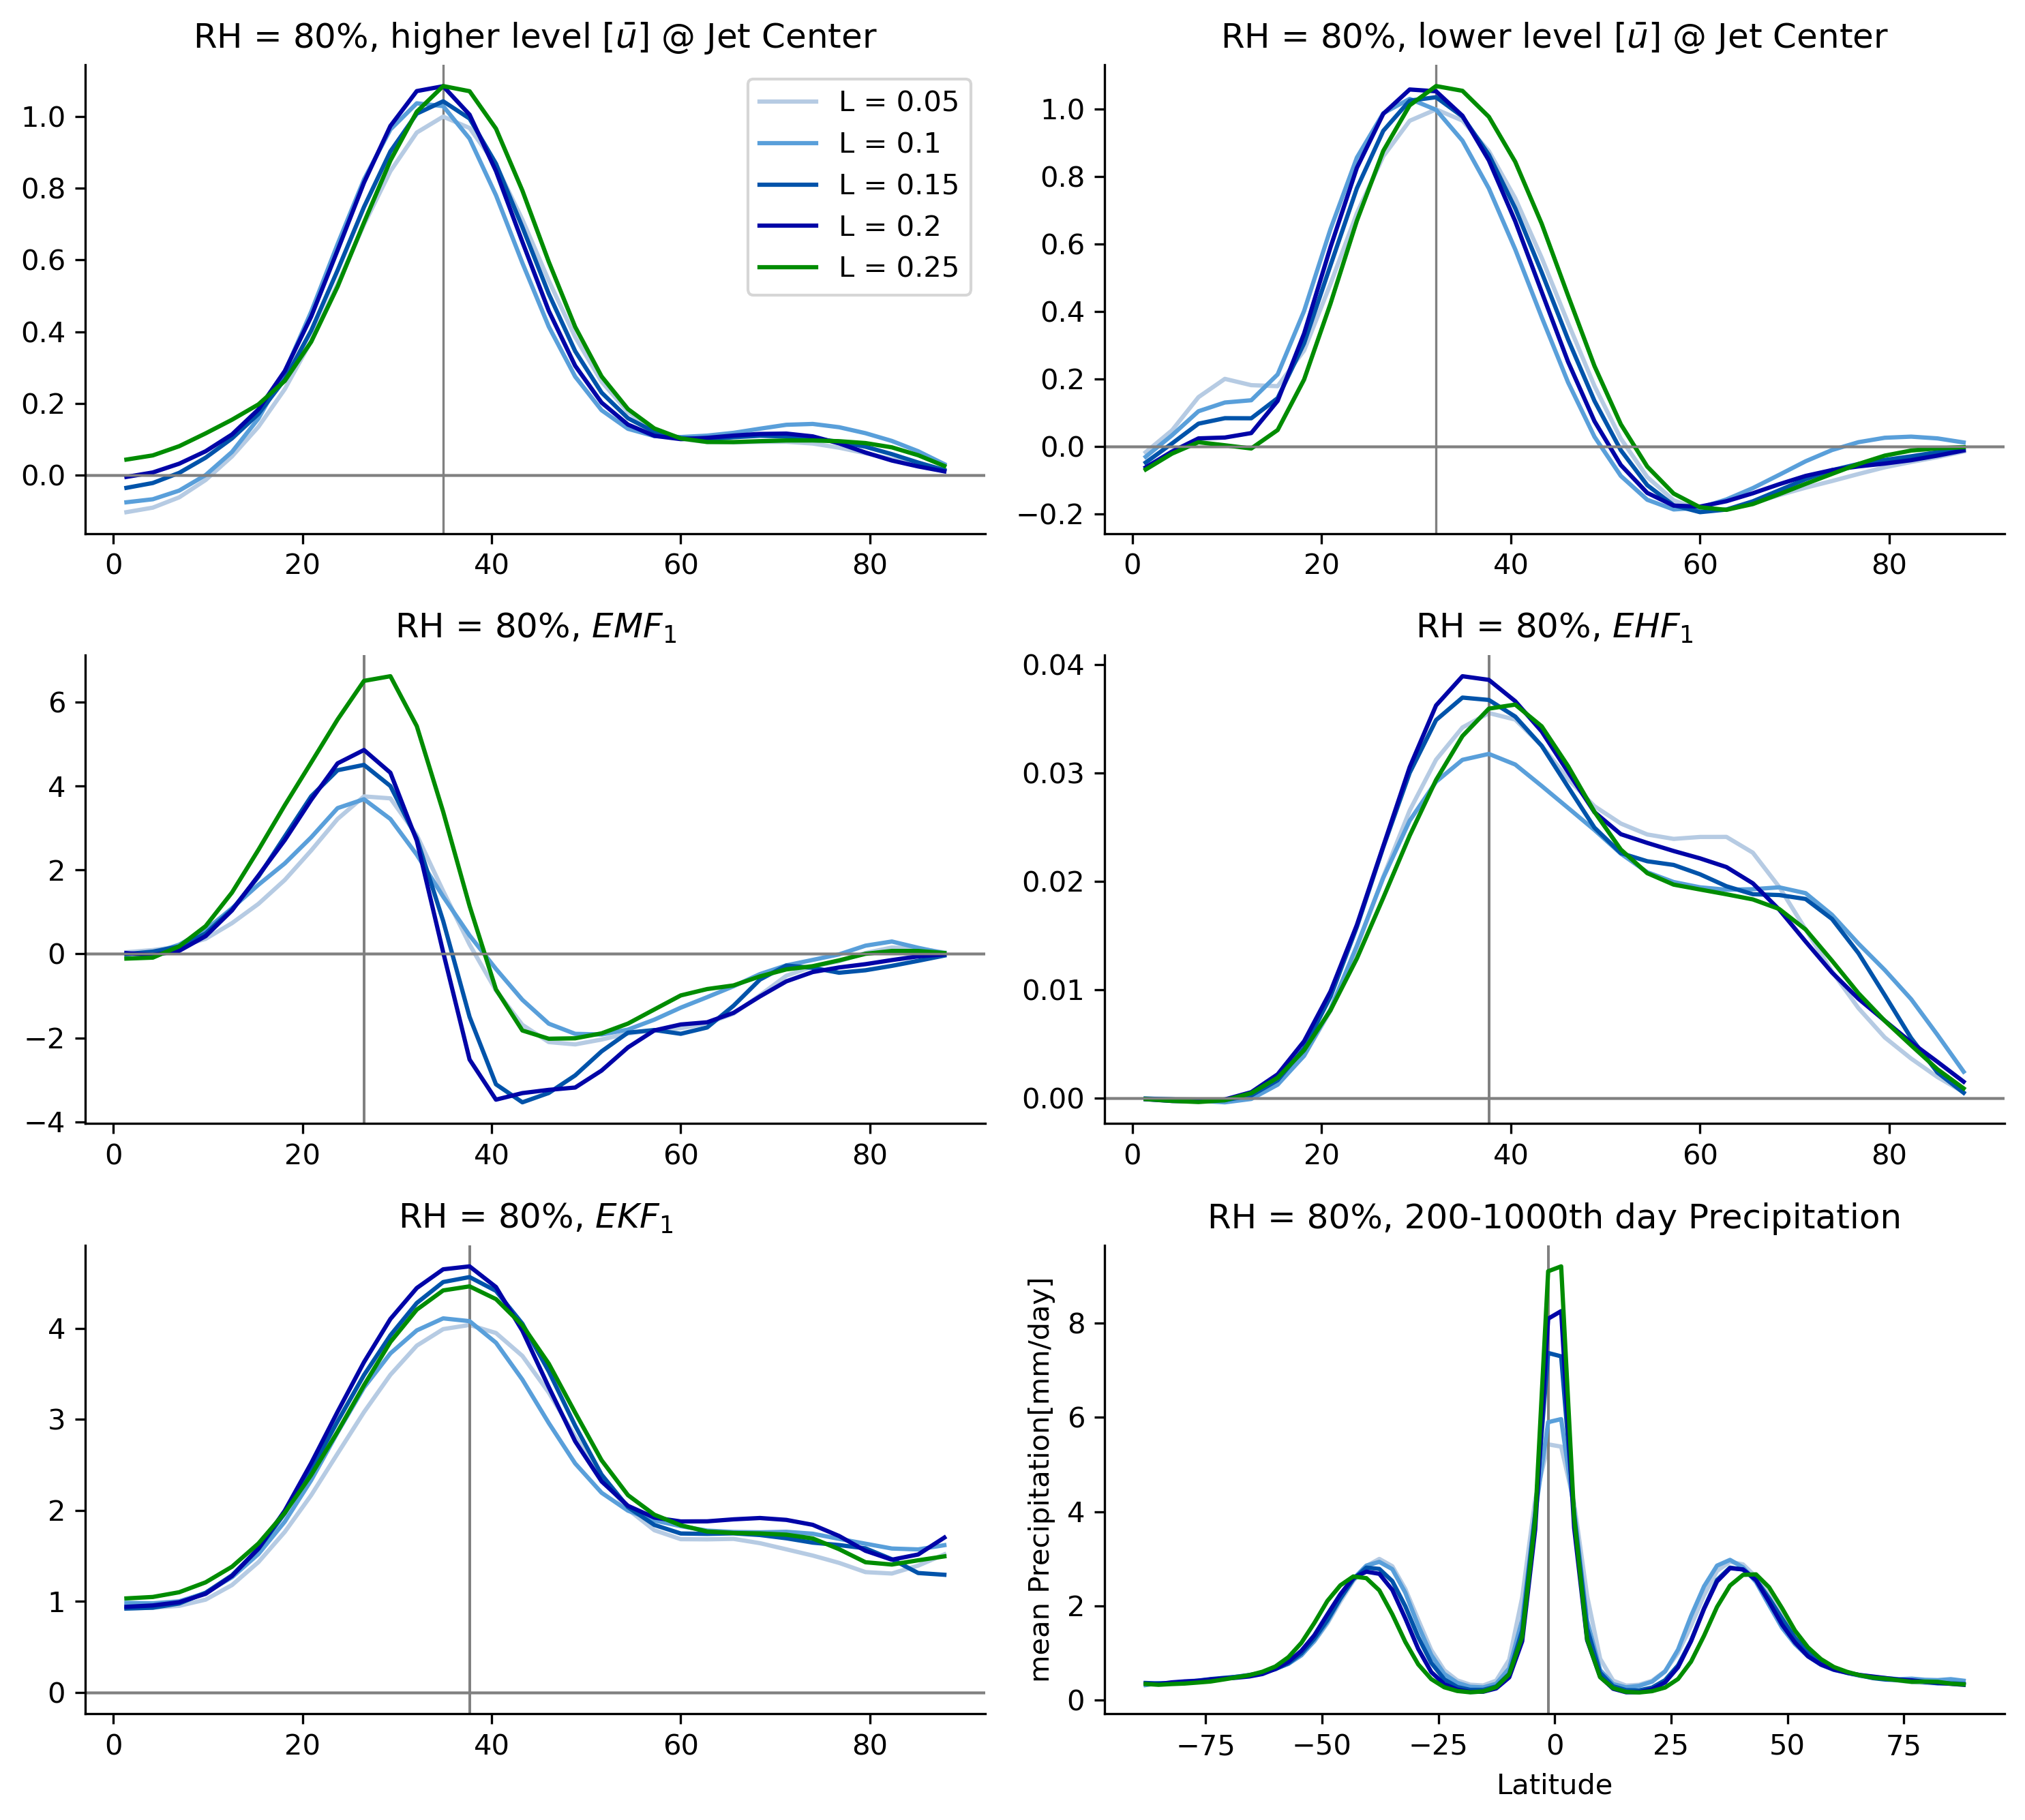

In [166]:
import matplotlib.colors as colors
import matplotlib as mpl

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255

for pr in range(5, 30, 5):
    print(pr)
    # file  = f"HS_front_RH80_PR{pr}_PRRELAX86400_all.dat" # ./outputs/withprecip/
    # file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_day0_500_all.dat" # ./outputs/withprecip/
    # file  = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"
    file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_1000day_final.dat"
    dycore = Dycore(file)
    #qv = dycore.getVar("grid_tracers_c_xyzt")
    #u = dycore.getVar("grid_u_c_xyzt")
    #v = dycore.getVar("grid_v_c_xyzt")
    #qv_diff = dycore.getVar("grid_tracers_diff_xyzt")
    
    #qv_diff_sum = np.nansum(qv_diff[:,:,:,:], axis=(0,1,3))

    qv_all = np.zeros(((9, 100, 20 , 64, 128)))
    qv_diff_all = np.zeros(((9, 100, 20 , 64, 128)))
    u_all = np.zeros(((9, 100, 20 , 64, 128)))
    v_all = np.zeros(((9, 100, 20 , 64, 128)))
    t_all = np.zeros(((9, 100, 20 , 64, 128)))
    p_all = np.zeros(((9, 100, 20 , 64, 128)))
    p_half_all = np.zeros(((9, 100, 21 , 64, 128)))

    a = 0
    for day in range(200,1100,100):
        print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        qv_all[a,:,:,:,:]   = dycore.qv
        qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        u_all[a,:,:,:,:]    = dycore.u
        v_all[a,:,:,:,:]    = dycore.v
        t_all[a,:,:,:,:]    = dycore.t
        p_all[a,:,:,:,:]    = dycore.p
        p_half_all[a,:,:,:,:]    = dycore.p_half
        
        print(a)
        a+=1
    qv_all_new      = np.nanmean(qv_all  , axis=0)
    qv_diff_new      = np.nanmean(qv_diff_all  , axis=0)
    u_new      = np.nanmean(u_all  , axis=0)
    v_new      = np.nanmean(v_all  , axis=0)
    t_new      = np.nanmean(t_all  , axis=0)
    p_new      = np.nanmean(p_all  , axis=0)
    p_half_new      = np.nanmean(p_half_all  , axis=0)
    


    qv = qv_all_new
    qv_diff = qv_diff_new
    u = u_new
    v = v_new
    t = t_new
    p = p_new
    p_half = p_half_new

    print(u.shape)
    tmp = np.nanmean(u[:,:,32:,:], axis=(0, 3))
    # k, i = np.unravel_index(tmp.argmax(), tmp.shape)
    k = 5
    print(k,i)
    ##################################################################################
    """
    # fig[0,0]
    """
    #Prec  = np.zeros(((9, 100, 64)))
    u_all = np.zeros(((9, 100, 20 , 64, 128)))
    a = 0
    for day in range(200,1100,100):
        print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        u_all[a,:,:,:,:]   = dycore.u
        print(a)
        a+=1
    u_new      = np.nanmean(u_all  , axis=0)

    u = u_new

    u_jet = u[:,k,32:,:]
    u_jet_zonal_time_mean = np.nanmean(u_jet, axis=(0, 2))
    u_max_idx = np.argmax(u_jet_zonal_time_mean)
    if pr == 5:
        # control = np.nanmax(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])
        control_high = np.nanmax(u_jet_zonal_time_mean)
        ax[0,0].axvline(x=lat_0[32:][u_max_idx], color='gray', lw=0.8)
        
    # ax[0,0].plot(lat_0[32:][u_max_idx-10:u_max_idx+25+1], u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1] / control, label=f"L = {pr/100}", color=colors[int(pr/5)])
    ax[0,0].plot(lat_0[32:][:], u_jet_zonal_time_mean[:] / control_high, label=f"L = {pr/100}", color=colors[int(pr/5)])

    ax[0,0].set_title(r"RH = 80%, higher level [$\bar{u}$] @ Jet Center")
    # ax[0,0].set_ylim(np.min(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])-2, np.max(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])+2)
    ax[0,0].axhline(y=0, color='gray', lw=0.8)
    # ax[0,0].set_xticks(np.arange(0,90,10))
    ax[0,0].legend()
    # ax[0,0].set_ylim([-0.05,2])
    # lat_0[32:][u_max_idx]
    # ax[0,0].set_xticks(np.linspace(lat_0[32:][u_max_idx]-30,lat_0[32:][u_max_idx]+40,7,dtype=np.int64),
                       # np.linspace(lat_0[32:][u_max_idx]-30 - lat_0[32:][u_max_idx],lat_0[32:][u_max_idx]+40 - lat_0[32:][u_max_idx],7, dtype=np.int64))
    # xticks = ax[0,0].get_xticks()
    # print(len(xticks))
    # ax[0,0].set_xticks(xticks-xticks[5])
    # ax[0,0].set_xticks(lat_0[32:][u_max_idx-10:u_max_idx+25+1][0::2])
    # ax[0,0].set_xticklabel(lat_0[32:][u_max_idx-10:u_max_idx+25+1][0::2])
    
    ax[0,0].spines["right"].set_visible(False)
    ax[0,0].spines["top"].set_visible(False)
    ##################################################################################
    """
    # fig[0,1]
    """
    # lower level
    k = 14
    u_jet = u[:,k,32:,:]
    u_jet_zonal_time_mean = np.nanmean(u_jet, axis=(0, 2))
    u_max_idx = np.argmax(u_jet_zonal_time_mean)
    if pr == 5:
        # control = np.nanmax(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])
        control_low = np.nanmax(u_jet_zonal_time_mean)
        ax[0,1].axvline(x=lat_0[32:][u_max_idx], color='gray', lw=0.8)
    # ax[0,1].plot(lat_0[32:][u_max_idx-10:u_max_idx+25+1], u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1] / control, label=f"L = {pr/100}", color=colors[int(pr/5)])
    ax[0,1].plot(lat_0[32:], u_jet_zonal_time_mean / control_low, label=f"L = {pr/100}", color=colors[int(pr/5)])

    ax[0,1].set_title(r"RH = 80%, lower level [$\bar{u}$] @ Jet Center")
    # ax[0,1].set_ylim([-0.3, 0.8])
    # ax[0,1].legend()
    ax[0,1].axhline(y=0, color='gray', lw=0.8)
    ax[0,1].spines["right"].set_visible(False)
    ax[0,1].spines["top"].set_visible(False)
    ##################################################################################
    """
    # fig[1,0]
    """
    EMF_max_idx = np.argmax(EMF_80[int(pr/5)])
    ax[1,0].set_title(r"RH = 80%, $EMF_{1}$")
    if pr == 5:
        ax[1,0].axvline(x=lat_0[32:][EMF_max_idx], color='gray', lw=0.95)
    # ax[1,0].plot(lat_0[32:][EMF_max_idx-10:EMF_max_idx+25+1], EMF_80[int(pr/5)][EMF_max_idx-10:EMF_max_idx+25+1]  , label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/5)])
    ax[1,0].plot(lat_0[32:], EMF_80[int(pr/5)], label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/5)])
    
    ax[1,0].axhline(y=0, color='gray', lw=0.8)

    # print(EHF_80.shape)
    # EMF_jet = EHF_80[:,k,32:,:]
    # EMF_zonal_time_mean = np.nanmean(EMF_index, axis=(0,2))
    # EMF_max_idx = np.argmax(EMF_zonal_time_mean)
    
    # if pr == 5:
    #     # control = np.nanmax(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])
    #     control_EMF = np.nanmax(EMF_zonal_time_mean)
    #     ax[0,0].axvline(x=lat_0[32:][u_max_idx], color='gray', lw=0.8)
        

    # ax[1,0].legend()
    ax[1,0].spines["right"].set_visible(False)
    ax[1,0].spines["top"].set_visible(False)
    ##################################################################################
    """
    # fig[1,1]
    """
    EHF_max_idx = np.argmax(EHF_80[int(pr/5)])
    ax[1,1].set_title(r"RH = 80%, $EHF_{1}$")
    # ax[1,1].plot(lat_0[32:][EHF_max_idx-10:EHF_max_idx+25+1], EHF_80[int(pr/5)][EHF_max_idx-10:EHF_max_idx+25+1]  , label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/5)])
    ax[1,1].plot(lat_0[32:], EHF_80[int(pr/5)], label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/5)])
    ax[1,1].axhline(y=0, color='gray', lw=0.8)
    if pr == 5:
        ax[1,1].axvline(x=lat_0[32:][EHF_max_idx], color='gray', lw=0.95)
    # ax[1,1].legend()
    ax[1,1].spines["right"].set_visible(False)
    ax[1,1].spines["top"].set_visible(False)
    ##################################################################################
    """
    # fig[2,0]
    """
    EKF_max_idx = np.argmax(EKF_80[int(pr/5)])
    ax[2,0].set_title(r"RH = 80%, $EKE_{1}$")
    # ax[2,0].plot(lat_0[32:][EKF_max_idx-8:EKF_max_idx+8+1], EKF_80[int(pr/5)][EKF_max_idx-8:EKF_max_idx+8+1]  , label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/5)])
    ax[2,0].plot(lat_0[32:][:], EKF_80[int(pr/5)][:]  , label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/5)])
    
    # ax[2,0].plot(lat_0[32:], EKF_80[int(pr/5)], label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/5)])
    ax[2,0].axhline(y=0, color='gray', lw=0.8)
    if pr == 5:
        ax[2,0].axvline(x=lat_0[32:][EKF_max_idx], color='gray', lw=0.95)
    # ax[2,0].legend()
    ax[2,0].spines["right"].set_visible(False)
    ax[2,0].spines["top"].set_visible(False)
    
    prec_max_idx = np.argmax(prec_80[int(pr/5),:])
    ax[2,1].plot(lat_0[:], prec_80[int(pr/5), :]  * 86400, label=f"L = {pr/100}", color=colors[int(pr/5)])
    ax[2,1].set_title(r"RH = 80%, 200-1000th day Precipitation")
    # ax[1,1].set_ylim(np.min(qv_diff_sum[u_max_idx-10:u_max_idx+25+1])-0.1, np.max(qv_diff_sum[u_max_idx-10:u_max_idx+25+1])+0.1)
    # ax[2,1].set_ylim(np.min(qv_diff_sum[P_max_idx-10:P_max_idx+25+1] * int(pr/5)/ int(np.size(qv_diff[-200:,0,0,0]))-0.5), np.max(qv_diff_sum[P_max_idx-10:P_max_idx+25+1] * int(pr/5))/ int(np.size(qv_diff[-200:,0,0,0]))+0.3)
    # ax[2,1].legend()
    if pr == 5:
        ax[2,1].axvline(x=lat_0[:][prec_max_idx], color='gray', lw=0.95)
    ax[2,1].set_ylabel("mean Precipitation[mm/day]")
    ax[2,1].set_xlabel("Latitude")
    ax[2,1].spines["right"].set_visible(False)
    ax[2,1].spines["top"].set_visible(False)
    

    

plt.savefig("RH80_test.png", dpi=300., bbox_inches='tight')
plt.tight_layout()
plt.show()

In [115]:
print(np.nanmax(qv_diff_sum))

0.002625911273356984
